## Net Returns Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> The net returns maximization module is experiemental. There are also a few working areas will be refined in the future version that should save the scatter commands in this tutorial </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level). Behind the scene, we use the `SLSQP` method from `scipy.optim`. It is recommended to learn basic from the [scipy manual](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy

# for version print
import orbit
import scipy

from karpiu.planning.optim import ChannelNetProfitMaximizer, TimeNetProfitMaximizer
from karpiu.planning.optim.time_base_optimizer import time_based_net_profit_response_curve
from karpiu.planning.optim.channel_optimizer import ch_based_net_profit_response_curve
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import AttributorGamma as Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(pd.__version__)
print(np.__version__)
print(scipy.__version__)

1.1.4.2
1.4.2
1.24.2
1.10.0


We reload the fitted model from previous `Quickstart` section here.

In [4]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

### Demo on Bivariate Inputs

In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-02")
optim_channels = mmm.get_spend_cols()[1:3]
optim_channels

['radio', 'search']

Given the customers life-time value (LTV), one can run the revenue maximization.

In [6]:
# provide some arbitrary ltv arrays
# they need to be in full channels length
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]

In [7]:
temp_mmm = deepcopy(mmm)
attributor = Attributor(model=temp_mmm, start=budget_start, end=budget_end)
# temp_mmm.raw_df = temp_optim_spend_df
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    attributor=attributor,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    spend_scaler=1.0,
    response_scaler=1.0,
)

2023-12-11 17:21:30 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-01-02
2023-12-11 17:21:30 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-01-02
2023-12-11 17:21:30 - karpiu-planning - INFO - Optimizing channels : ['radio', 'search']


We can leverage the module `time_based_net_profit_response_curve` (only works for bivariate inputs) to plot the surface of the response and then add the track footprint from each optimization step.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11646.745792149977
            Iterations: 24
            Function evaluations: 73
            Gradient evaluations: 24
CPU times: user 4.13 s, sys: 35.3 ms, total: 4.17 s
Wall time: 4.15 s


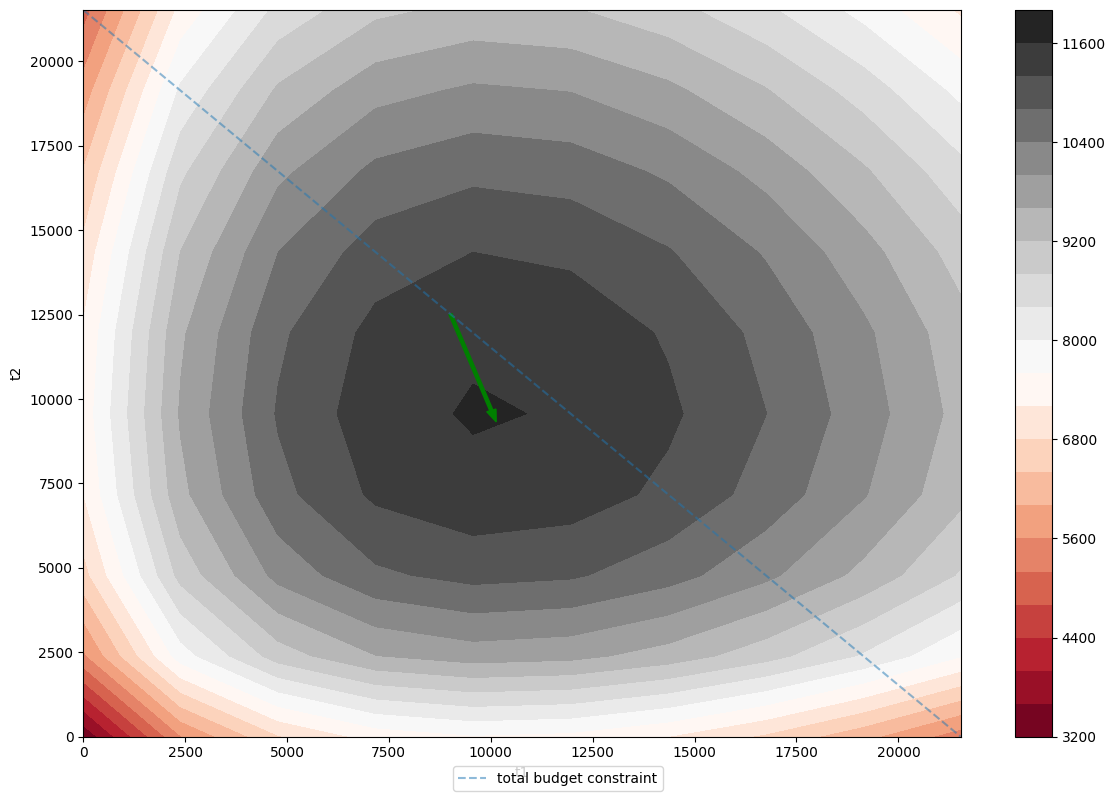

In [8]:
%%time
x, y, z = time_based_net_profit_response_curve(t_npm=t_npm, model=temp_mmm, n_iters=10)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cs = ax.contourf(x, y, z, 20, cmap='RdGy')
fig.colorbar(cs, ax=ax)
ax.set_xlabel('t1')
ax.set_ylabel('t2')
ax.plot([0, t_npm.total_budget], [t_npm.total_budget, 0], alpha=0.5, label='total budget constraint', linestyle='--')

# run optim steps
t_optim_df = t_npm.optimize(maxiter=500)

# use callback metrics to extract solutions on each step
callback_metrics = t_npm.get_callback_metrics()
xs = np.array(callback_metrics['xs'])
ax.arrow(
    x=xs[0, 0], 
    y=xs[0, 1], 
    dx=xs[-1, 0] - xs[0, 0], 
    dy=xs[-1, 1] - xs[0, 1], 
    width=80,
    color='green',
)
fig.legend(loc='lower center')
fig.tight_layout()

The `ChannelNetProfitMaximizer` share similar interface to perform channel based optimization.

In [9]:
temp_mmm = deepcopy(mmm)
attributor = Attributor(model=temp_mmm, start=budget_start, end=budget_end)
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    attributor=attributor,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.0,
    response_scaler=1.0,
)

2023-12-11 17:21:35 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-01-02
2023-12-11 17:21:35 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-01-02
2023-12-11 17:21:35 - karpiu-planning - INFO - Optimizing channels : ['radio', 'search']


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17929.022112135015
            Iterations: 11
            Function evaluations: 33
            Gradient evaluations: 11
CPU times: user 3.95 s, sys: 27.2 ms, total: 3.97 s
Wall time: 3.94 s


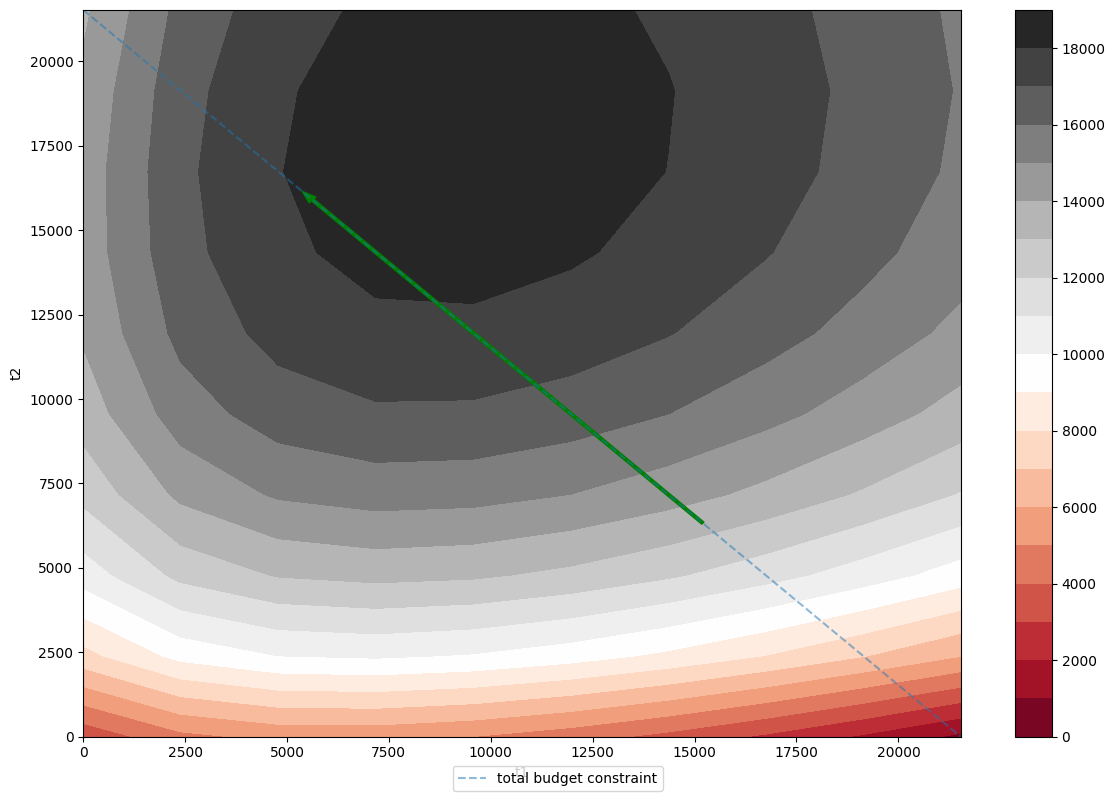

In [10]:
%%time
x, y, z = ch_based_net_profit_response_curve(ch_npm=ch_npm, model=temp_mmm, n_iters=10)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cs = ax.contourf(x, y, z, 20, cmap='RdGy')
fig.colorbar(cs, ax=ax)
ax.set_xlabel('t1')
ax.set_ylabel('t2')
ax.plot([0, ch_npm.total_budget], [ch_npm.total_budget, 0], alpha=0.5, label='total budget constraint', linestyle='--')

# run optim steps
cn_optim_df = ch_npm.optimize(maxiter=500)

# use callback metrics to extract solutions on each step
callback_metrics = ch_npm.get_callback_metrics()
xs = np.array(callback_metrics['xs'])
ax.arrow(
    x=xs[0, 0], 
    y=xs[0, 1], 
    dx=xs[-1, 0] - xs[0, 0], 
    dy=xs[-1, 1] - xs[0, 1], 
    width=80,
    color='green',
)
fig.legend(loc='lower center')
fig.tight_layout()

### Two-Stage Optimization

We can also chain the two stages together. Let's see what happen. In practice, one can iteratively call these two methods.

In [11]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-03-31")
optim_channels = mmm.get_spend_cols()

Given the customers life-time value (LTV), one can run the revenue maximization.

#### Optimizing Channel Budget

First, we optimize the budget mix.

In [12]:
%%time
attributor = Attributor(model=temp_mmm, start=budget_start, end=budget_end)
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    attributor=attributor,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.0,
    response_scaler=1.0,
)

2023-12-11 17:21:39 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:39 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:39 - karpiu-planning - INFO - Optimizing channels : ['promo', 'radio', 'search', 'social', 'tv']


CPU times: user 201 ms, sys: 2.54 ms, total: 204 ms
Wall time: 69.7 ms


In [13]:
temp_optim_spend_df = ch_npm.optimize(maxiter=500, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -353153.70395099116
            Iterations: 74
            Function evaluations: 444
            Gradient evaluations: 74


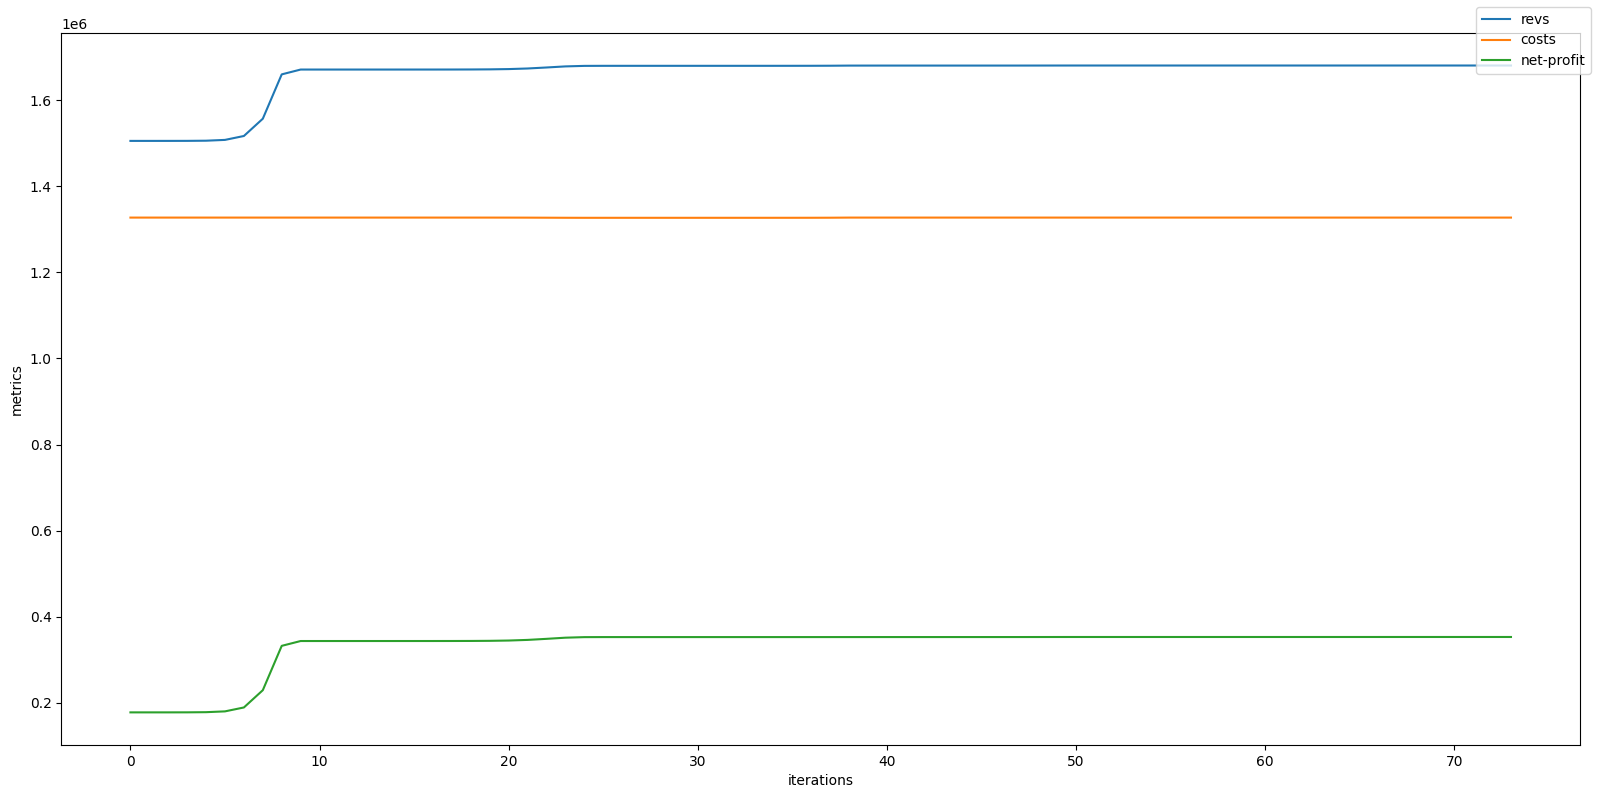

In [14]:
# expermential plot the revs and costs
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
callback_metrics = ch_npm.get_callback_metrics()

optim_revenues = np.array(callback_metrics["optim_revenues"])
optim_costs = np.array(callback_metrics["optim_costs"])

ax.plot(optim_revenues, label="revs")
ax.plot(optim_costs, label="costs")
ax.plot(optim_revenues - optim_costs, label="net-profit")
ax.set_xlabel("iterations")
ax.set_ylabel("metrics")
fig.legend()
fig.tight_layout();

We can retreive the initial and final state of the optimization.

In [15]:
channel_spend_arr = ch_npm.get_current_state()
init_spend_arr = ch_npm.get_init_state()
init_spend_matrix = ch_npm.get_init_spend_matrix()

In [16]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(channel_spend_arr)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_arr)))

Suggested total spend: 1327092
Total Budget: 1327092


#### Optimizing Budget Allocation across Time

Second, given the condition of budget mix, we optimize the allocation across time.

In [17]:
%%time
temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df
attributor = Attributor(model=temp_mmm, start=budget_start, end=budget_end)
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    attributor=attributor,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    spend_scaler=1.0,
    response_scaler=1.0,
)

2023-12-11 17:21:39 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:39 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:39 - karpiu-planning - INFO - Optimizing channels : ['promo', 'radio', 'search', 'social', 'tv']


CPU times: user 195 ms, sys: 3.94 ms, total: 199 ms
Wall time: 68.5 ms


In [18]:
optim_spend_df = t_npm.optimize(maxiter=500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -585281.2963156031
            Iterations: 371
            Function evaluations: 33671
            Gradient evaluations: 370


In [19]:
optim_spend_matrix = t_npm.get_current_spend_matrix()

In [20]:
time_based_spend_arr = t_npm.get_current_state()

In [21]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 1327092
Total Budget: 1327092


### Validation

#### Average and Marginal Cost Change

In general, one should expect when LTV is greater than the marginal cost under the pre-optimized spend, there should be an increase of spend in the optimal budget. 

In [22]:
df = mmm.get_raw_df()

In [23]:
cost_report = generate_cost_report(
    model=mmm,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

2023-12-11 17:21:44 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:44 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:44 - karpiu-planning - INFO - Full calculation start=2021-01-01 and end=2021-03-31
2023-12-11 17:21:44 - karpiu-planning - INFO - Attribution start=2021-01-01 and end=2021-03-31


,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,pre-opt-attr,post-opt-attr,ltv
promo,41.56216,28.70818,41.28361,45.01549,145.95900,153.31830,3511.82429,5340.57816,48.50000
radio,65.77044,32.33169,49.65129,50.74166,294.95500,179.14091,4484.61328,5540.72241,52.50000
search,27.12460,25.31975,23.30565,35.27171,240.82900,549.17303,8878.61992,21689.51500,38.60000
social,29.48616,22.48012,23.57794,33.45444,171.27100,273.80843,5808.52155,12180.02265,35.80000
tv,89.58398,38.09382,76.53350,59.44528,474.07800,171.65133,5291.99524,4506.01507,60.80000


In [24]:
pre_mc = cost_report["pre-opt-marginal-cost"].values
overspend = pre_mc > (cost_report["ltv"].values * 1.2)
underspend = pre_mc < (cost_report["ltv"].values * 0.8)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

After all, a general condition of marginal cost lower than LTV should be met when spend > 0.

In [25]:
post_mc = cost_report["post-opt-marginal-cost"].values

In [26]:
assert np.all(post_mc < cost_report["ltv"].values * 1.1)

#### Spend Allocation Plot

Channels mix comparison

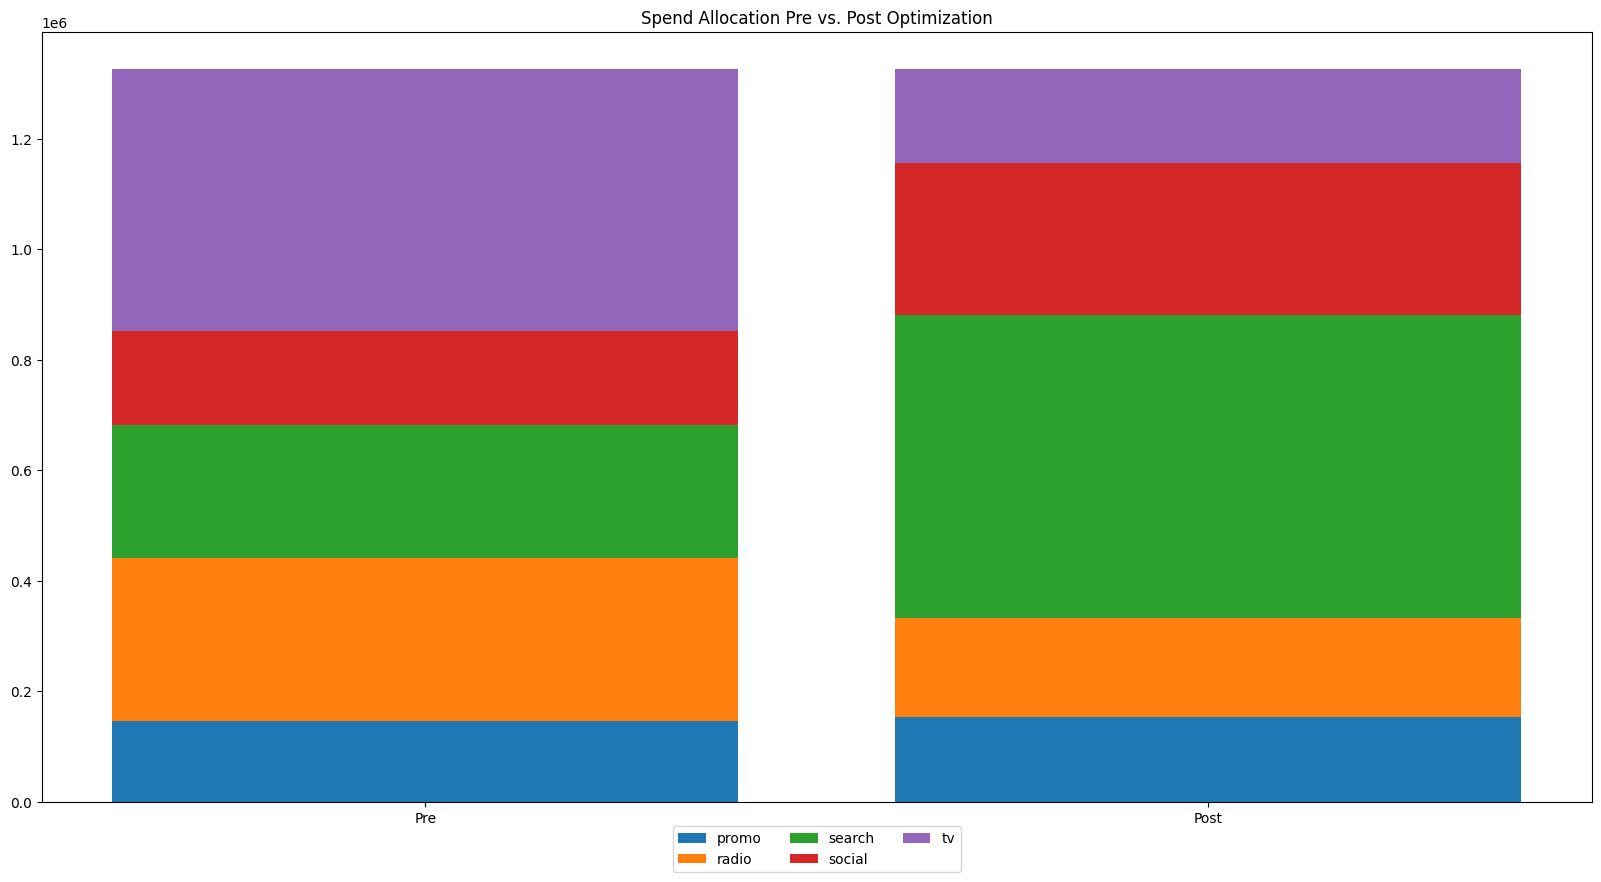

In [27]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

One way to validate time-base budget is to compare with the organic. Due to the multiplicative properties, they should be propertional to each other.

The `MMMShell` object serves a snapshot purpose of a MMM object.

<div class="alert alert-block alert-info"> <b>NOTE</b> In the future, both the shell object and the optimizer should be maintained by some inheritance relationship. </div>

In [28]:
from karpiu.model_shell import MMMShell
msh = MMMShell(temp_mmm)
init_df = temp_mmm.get_raw_df()
organic_attr_arr = msh.attr_organic[
    (init_df[temp_mmm.date_col] >= budget_start) & (init_df[temp_mmm.date_col] <= budget_end)
]

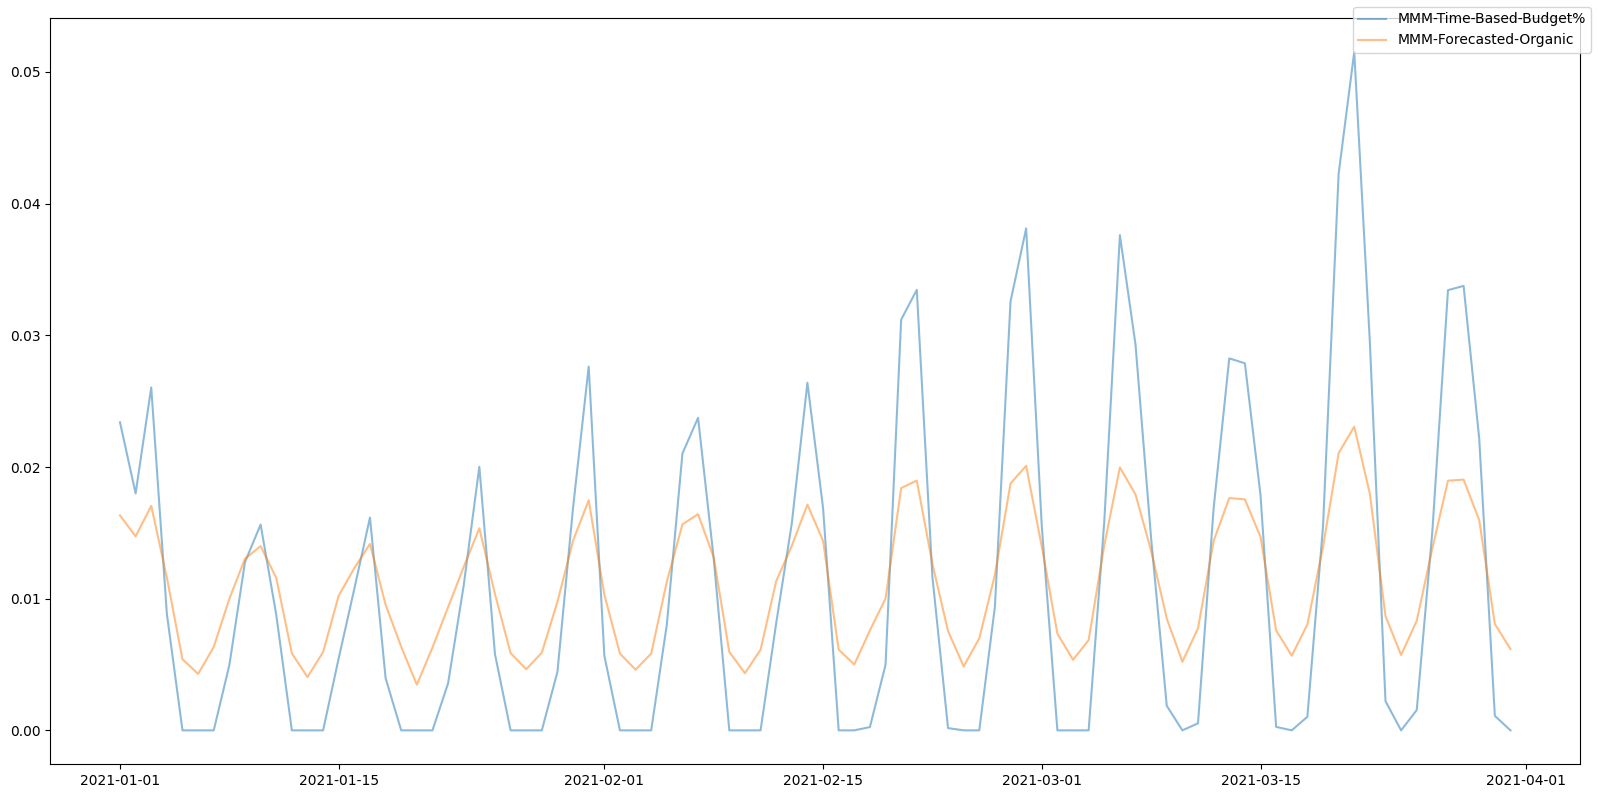

In [29]:
t_based_allocation_comp = t_npm.get_current_state()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    pd.date_range(budget_start, budget_end, freq="1D"),
    t_based_allocation_comp / np.sum(t_based_allocation_comp),
    label="MMM-Time-Based-Budget%",
    alpha=0.5,
)
ax.plot(
    pd.date_range(budget_start, budget_end, freq="1D"),
    organic_attr_arr / np.sum(organic_attr_arr),
    label="MMM-Forecasted-Organic",
    alpha=0.5,
)
fig.legend()
fig.tight_layout()

### Customize Budget Constraints and Bounds

#### Channels mix

The channel "total" is a special reserved to specify total budget constraint. When lower bound and upper bound are equal, it enforce the budget total fixed.

In [30]:
bounds_and_constraints_df = pd.DataFrame(
    {
        "channels": optim_channels + ["total"],
        "upper": np.array(
            [291918.0, 589910.0, 481658.0, 342542.0, 948156.0, 1327092.0]
        ),
        "lower": np.array([14595.9, 29495.5, 24082.9, 17127.1, 47407.8, 1327092.0]),
    }
)
bounds_and_constraints_df

,channels,upper,lower
0,promo,291918.00000,14595.90000
1,radio,589910.00000,29495.50000
2,search,481658.00000,24082.90000
3,social,342542.00000,17127.10000
4,tv,948156.00000,47407.80000
5,total,1327092.00000,1327092.00000


In [31]:
ch_npm.set_bounds_and_constraints(df=bounds_and_constraints_df)

2023-12-11 17:21:44 - karpiu-planning - INFO - Set bounds.
2023-12-11 17:21:44 - karpiu-planning - INFO - Set total budget constraints.


#### Time-based allocaton

Similar to channels mix, "total" is a reserved keyword.

In [32]:
bounds_and_constraints_df = pd.DataFrame(
    {
        "date": t_npm.df.loc[t_npm.budget_mask, "date"].astype(str).to_list()
        + ["total"],
        "upper": np.concatenate(
            [np.ones(t_npm.n_budget_steps) * 30000, np.ones(1) * 1327092]
        ),
        "lower": np.concatenate([np.zeros(t_npm.n_budget_steps), np.ones(1) * 1327092]),
    }
)
bounds_and_constraints_df

,date,upper,lower
0,2021-01-01,30000.00000,0.00000
1,2021-01-02,30000.00000,0.00000
2,2021-01-03,30000.00000,0.00000
3,2021-01-04,30000.00000,0.00000
4,2021-01-05,30000.00000,0.00000
...,...,...,...
86,2021-03-28,30000.00000,0.00000
87,2021-03-29,30000.00000,0.00000
88,2021-03-30,30000.00000,0.00000
89,2021-03-31,30000.00000,0.00000


In [33]:
t_npm.set_bounds_and_constraints(bounds_and_constraints_df)

2023-12-11 17:21:44 - karpiu-planning - INFO - Set bounds.
2023-12-11 17:21:44 - karpiu-planning - INFO - Set total budget constraints.
